In [1]:
# for data cleaning and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

# for modelling
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore')

In [2]:
# unzip the data zip file
ZIP_PATH = 'predict-viral-instagram-posts-advanced.zip' # zip file's path
with ZipFile(ZIP_PATH, 'r') as zipObj:
   zipObj.extractall()

In [2]:
# read in files
df_metadata = pd.read_csv('metadata.csv')
df_train = pd.read_csv('train_advance.csv')
df_test = pd.read_csv('test_advance.csv')

In [5]:
df_metadata

,Field,Description
0,SID,Sequence ID
1,ID,Instagrams ID for that could be used on the we...
2,Name,Locations Name
3,Streen,"Streed Address, may contain '\n'"
4,ZIP,Zip code
5,City,City Name
6,Region,Region
7,CD,Country Code
8,Phone,The phone in format as on the Instragram
9,aj_exact_city_match,The Instagrams Internal key


## Train dataset

### Data cleaning

In [7]:
df_train.head()

,Unnamed: 0.1,Unnamed: 0,location_id,profile_id,sid,sid_profile,post_id,post_type,description,numbr_likes,...,region,cd,phone,aj_exact_city_match,aj_exact_country_match,blurb,dir_city_name,dir_country_name,lat,lng
0,11420,11755,340283947,829324748,28919418,295070,Bka_6xunYma,1,Cheers to wine O‚Äôclock ü•Ç (üì∏: @aob1085),4985,...,NaN,ES,+34 936 65 77 41,False,False,NaN,El Prat de Llobregat,Spain,2,41
1,24264,24967,2631322,199074048,42114489,4342099,BxaZS4fA_nV,1,#malcapuyaisland #bananaisland #bulogisland,57,...,NaN,PH,NaN,True,False,NaN,Coron,Philippines,120,11
2,16286,16768,668571209,3280121227,19193237,2554203,BxmEzQUFocM,1,üî∏\\nSchwarzkehlchen (Saxicola rubicola) ‚Ä¢...,1576,...,Saxony-Anhalt,DE,NaN,False,True,NaN,NaN,NaN,11,51
3,11139,11467,238461670,5625643374,11733129,3465973,Bjq5KFGlJvM,1,Eared Grebe spotted at one of my favourite spo...,29,...,NaN,CA,NaN,True,False,NaN,NaN,NaN,-118,52
4,27320,28111,1005642734,1557071010,8540244,3541402,BweviowATmj,1,–ü–õ–ê–ö–ê–¢–¨ –í –ú–û–°–¢–ê–• - –≠–¢–û –ù–û–†...,1487,...,NaN,RU,79214201362,False,False,—Ü–µ–Ω—Ç—Ä –∏–Ω–∏—Ü–∏–∞—Ü–∏–∏ —Ç–≤–æ—Ä—á–µ—Å—Ç...,Aptekarskiy,Russia,30,59


In [8]:
# examine the shape of train dataframe
df_train.shape

(22924, 31)

In [11]:
# examine all column names
df_train.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'location_id', 'profile_id', 'sid',
       'sid_profile', 'post_id', 'post_type', 'description', 'numbr_likes',
       'number_comments', 'profile_name', 'firstname_lastname', 'following',
       'followers', 'n_posts', 'url', 'is_business_account', 'name', 'zip',
       'city', 'region', 'cd', 'phone', 'aj_exact_city_match',
       'aj_exact_country_match', 'blurb', 'dir_city_name', 'dir_country_name',
       'lat', 'lng'],
      dtype='object')

In [3]:
# drop the first two unnamed columns
df_train = df_train[[col for col in df_train.columns[2:]]]
df_train.head()

,location_id,profile_id,sid,sid_profile,post_id,post_type,description,numbr_likes,number_comments,profile_name,...,region,cd,phone,aj_exact_city_match,aj_exact_country_match,blurb,dir_city_name,dir_country_name,lat,lng
0,340283947,829324748,28919418,295070,Bka_6xunYma,1,Cheers to wine O‚Äôclock ü•Ç (üì∏: @aob1085),4985,78,oprahmagazine,...,NaN,ES,+34 936 65 77 41,False,False,NaN,El Prat de Llobregat,Spain,2,41
1,2631322,199074048,42114489,4342099,BxaZS4fA_nV,1,#malcapuyaisland #bananaisland #bulogisland,57,2,jpadi_33,...,NaN,PH,NaN,True,False,NaN,Coron,Philippines,120,11
2,668571209,3280121227,19193237,2554203,BxmEzQUFocM,1,üî∏\\nSchwarzkehlchen (Saxicola rubicola) ‚Ä¢...,1576,15,m4r10_p13ch4ty,...,Saxony-Anhalt,DE,NaN,False,True,NaN,NaN,NaN,11,51
3,238461670,5625643374,11733129,3465973,Bjq5KFGlJvM,1,Eared Grebe spotted at one of my favourite spo...,29,5,vagabondesi,...,NaN,CA,NaN,True,False,NaN,NaN,NaN,-118,52
4,1005642734,1557071010,8540244,3541402,BweviowATmj,1,–ü–õ–ê–ö–ê–¢–¨ –í –ú–û–°–¢–ê–• - –≠–¢–û –ù–û–†...,1487,11,elena__mirra,...,NaN,RU,79214201362,False,False,—Ü–µ–Ω—Ç—Ä –∏–Ω–∏—Ü–∏–∞—Ü–∏–∏ —Ç–≤–æ—Ä—á–µ—Å—Ç...,Aptekarskiy,Russia,30,59


In [24]:
# check for duplicated rows
df_train[df_train.duplicated()]

,location_id,profile_id,sid,sid_profile,post_id,post_type,description,numbr_likes,number_comments,profile_name,...,region,cd,phone,aj_exact_city_match,aj_exact_country_match,blurb,dir_city_name,dir_country_name,lat,lng
3275,48155,13020967320,39216808,3872873,BxSwqIaHG87,1,Diagon Ally,4,0,stefspitzig,...,NaN,GB,+44 1904 652915,False,False,NaN,NaN,NaN,-1,53
4313,252754719,10136621406,26969150,3304646,Bx_x-7UHaM6,2,NaN,0,0,iuranirones,...,NaN,MD,NaN,False,False,NaN,NaN,NaN,29,47
5085,287799875168712,10673102630,14225612,3593302,BxHsFWgn3Ra,2,NaN,2,0,q3pk7jyz,...,NaN,US,(305) 918-4040,False,False,NaN,NaN,NaN,-80,25
5242,228449875,10121739155,40330392,4032830,By8ZQa8iXQX,1,–ó–∞–∫–∞—Ç –Ω–∞–¥ –ü–µ—Ä—Ç–æ–∑–µ—Ä–æ–º,3,1,elenasorokina624,...,Republic of Karelia,RU,NaN,False,True,NaN,Shukogora,Russia,33,63
5430,607036219,1578979708,10983296,2497063,Bd_63ughbMj,1,NATURAL ADVANCED BASE YG BERASASKAN AQUA YANG ...,1,0,leezabeauty_,...,Kuala Lumpur,MY,NaN,False,True,NaN,Kuala Lumpur,Malaysia,101,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22203,231262554313921,11473585979,8442382,3204481,BxGuKM_Hu2C,1,üòç extensive star major extensive üòÑ P...,0,0,uylkfonx,...,NaN,US,(305) 769-0274,False,False,NaN,NaN,NaN,-80,25
22225,55898,373092065,14697872,373564,BxOgzXsh-D4,1,NaN,4,0,eviechevy11,...,NaN,US,(212) 995-0333,False,False,NYC's original billiards club located in the h...,NaN,NaN,-73,40
22368,125019806,7947008573,43015191,4467442,BxUV7UNAUN-,1,2011,3,0,vladislavlishtvan2004,...,NaN,RU,NaN,True,False,NaN,K√§kisalmi,Russia,30,61
22381,214395308,3204686307,22726704,2893562,BVb_Ka2hAgD,1,Love this #NewNESTEA Slightly Sweet tea! #Free...,4,0,essentiallybellalove,...,NaN,US,NaN,True,False,NaN,Arcadia,United States,-118,34


There are 99 duplicated rows. These will be removed from the dataframe.

In [4]:
# drop duplicated rows and check the updated dataframe shape
df_train.drop_duplicates(inplace=True)
df_train.shape

(22825, 29)

Based on the metadata, several predictors which could be useful for the prediction are shortlisted:
- `post_type`
- `number_comments`
- `following`
- `followers`
- `n_posts`
- `is_business_account`
- `lat`
- `lng`

In [5]:
# keep relevant variables
predictors = ['post_type', 'number_comments', 'following', 'followers', 'n_posts', 'is_business_account', 'lat', 'lng', 'numbr_likes']
df_train = df_train[[col for col in predictors]]
df_train.head()

,post_type,number_comments,following,followers,n_posts,is_business_account,lat,lng,numbr_likes
0,1,78,420,594895,3612.0,True,2,41,4985
1,1,2,486,428,95.0,False,120,11,57
2,1,15,5378,36618,1259.0,True,11,51,1576
3,1,5,62,126,39.0,False,-118,52,29
4,1,11,544,45450,1251.0,True,30,59,1487


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22825 entries, 0 to 22923
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_type            22825 non-null  int64  
 1   number_comments      22825 non-null  int64  
 2   following            22825 non-null  object 
 3   followers            22825 non-null  int64  
 4   n_posts              22820 non-null  float64
 5   is_business_account  22820 non-null  object 
 6   lat                  22825 non-null  int64  
 7   lng                  22825 non-null  int64  
 8   numbr_likes          22825 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 1.7+ MB


Some columns are not in the correct data type, so conversion will be performed.

In [7]:
# check rows with invalid values in following column
df_train.loc[df_train['following'].str.contains(r'\D')]

,post_type,number_comments,following,followers,n_posts,is_business_account,lat,lng,numbr_likes
3535,1,26,2019-08-17 19:53:49.795000,0,NaN,NaN,139,35,1840
10687,1,33,2019-05-09 06:30:16.633000,0,NaN,NaN,-2,53,1935
17844,1,13,2019-07-16 12:32:59.400000,1,NaN,NaN,0,51,1225
22109,1,1,2019-03-26 23:58:10.746000,0,NaN,NaN,-118,33,84
22571,1,30,2019-05-09 06:30:16.633000,0,NaN,NaN,-89,21,3632


The `following` column is shown to be of object type, which suggests there might be invalid values (values other tahn numbers) in the column. By further examination, these rows might be invalid as there are two null values. Since there are just very few rows, they will be removed.

In [8]:
# drop the invalid rows
df_train.drop(df_train.index[df_train['following'].str.contains(r'\D')], inplace = True)

In [9]:
# convert columns to the correct data types
df_train['following'] = pd.to_numeric(df_train['following'])
df_train['n_posts'] = df_train['n_posts'].astype(int)
df_train['is_business_account'] = df_train['is_business_account'].replace({True: 1, False: 0})

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22820 entries, 0 to 22923
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   post_type            22820 non-null  int64
 1   number_comments      22820 non-null  int64
 2   following            22820 non-null  int64
 3   followers            22820 non-null  int64
 4   n_posts              22820 non-null  int64
 5   is_business_account  22820 non-null  int64
 6   lat                  22820 non-null  int64
 7   lng                  22820 non-null  int64
 8   numbr_likes          22820 non-null  int64
dtypes: int64(9)
memory usage: 1.7 MB


The columns are now in the correct data types. By removing the invalid rows, the null values previously in `n_posts` and `is_business_account` have now been removed as well.

In [10]:
# write the cleaned train dataset to file
df_train.to_csv('train_advance_cleaned.csv')

### Exploratory analysis

In [68]:
# check the range of values of each column
df_train.describe()

,post_type,number_comments,following,followers,n_posts,is_business_account,lat,lng,numbr_likes
count,22820.000000,22820.000000,2.282000e+04,2.282000e+04,22820.000000,22820.000000,22820.000000,22820.000000,22820.000000
mean,1.027958,76.258896,1.580469e+03,2.342315e+05,1640.209641,0.570684,-7.154733,38.004251,4738.458238
std,0.164856,774.648082,2.133803e+04,9.620985e+05,2606.945097,0.494989,67.532912,20.494125,17829.073760
min,1.000000,0.000000,0.000000e+00,4.000000e+00,1.000000,0.000000,-179.000000,-89.000000,0.000000
25%,1.000000,4.000000,3.790000e+02,2.411000e+03,251.000000,0.000000,-73.000000,34.000000,209.750000
50%,1.000000,18.000000,7.770000e+02,2.849100e+04,766.000000,1.000000,0.000000,42.000000,1355.000000
75%,1.000000,52.000000,1.531250e+03,1.372375e+05,1964.000000,1.000000,37.000000,51.000000,3137.000000
max,2.000000,95204.000000,2.279094e+06,3.533971e+07,60330.000000,1.000000,179.000000,73.000000,544129.000000


The range of values for the continuous predictors - `number_comments`, `following`, `followers`, `n_posts` - is very big, but it does reflect the reality. Hence, outliers will not be considered for these predictors.

Google search shows that the range of latitude is \[-90,90\] and the range of longitude is \[-180,180\]. Based on the range of values shown above, it is likely that the column names for latitude and longitude were switched. Hence, the column names will be corrected.

In [11]:
# switch the column names of latitude and longitude
df_train.rename(columns = {'lat':'lng', 'lng':'lat'}, inplace = True)

In [12]:
# check that the column names have been switched
df_train.describe()

,post_type,number_comments,following,followers,n_posts,is_business_account,lng,lat,numbr_likes
count,22820.000000,22820.000000,2.282000e+04,2.282000e+04,22820.000000,22820.000000,22820.000000,22820.000000,22820.000000
mean,1.027958,76.258896,1.580469e+03,2.342315e+05,1640.209641,0.570684,-7.154733,38.004251,4738.458238
std,0.164856,774.648082,2.133803e+04,9.620985e+05,2606.945097,0.494989,67.532912,20.494125,17829.073760
min,1.000000,0.000000,0.000000e+00,4.000000e+00,1.000000,0.000000,-179.000000,-89.000000,0.000000
25%,1.000000,4.000000,3.790000e+02,2.411000e+03,251.000000,0.000000,-73.000000,34.000000,209.750000
50%,1.000000,18.000000,7.770000e+02,2.849100e+04,766.000000,1.000000,0.000000,42.000000,1355.000000
75%,1.000000,52.000000,1.531250e+03,1.372375e+05,1964.000000,1.000000,37.000000,51.000000,3137.000000
max,2.000000,95204.000000,2.279094e+06,3.533971e+07,60330.000000,1.000000,179.000000,73.000000,544129.000000


In [70]:
# obtain distribution of post_type
post_type = df_train['post_type'].value_counts()
post_type 

1    22182
2      638
Name: post_type, dtype: int64

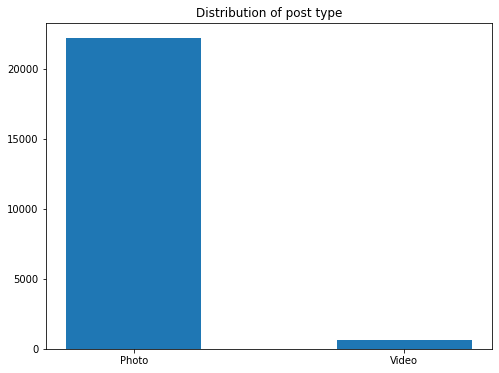

In [73]:
# visualise distribution of post type
plt.figure(figsize=(8,6))
plt.bar(['Photo', 'Video'], post_type, width=0.5)
plt.title('Distribution of post type')
plt.show()

The majority of posts are in the form of photos.

In [71]:
# obtain distribution of business account
business_acc = df_train['is_business_account'].value_counts()
business_acc 

1    13023
0     9797
Name: is_business_account, dtype: int64

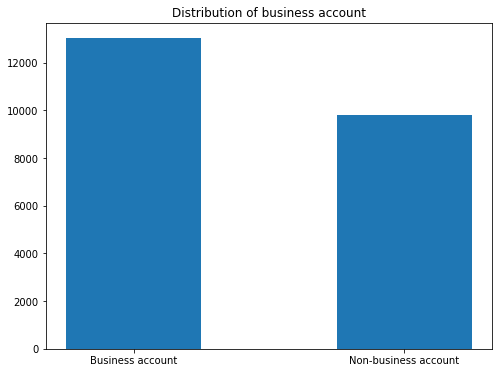

In [72]:
# visualise distribution of business account
plt.figure(figsize=(8,6))
plt.bar(['Business account', 'Non-business account'], business_acc, width=0.5)
plt.title('Distribution of business account')
plt.show()

The majority of accounts are business accounts.

### Feature engineering

Before fitting a regression model, the `post_type` column has to be one-hot encoded to be transformed into continuous variables.

In [13]:
# one-hot encode post type column
ohe = OneHotEncoder()
df_train[['is_photo', 'is_video']] = ohe.fit_transform(df_train[['post_type']]).toarray()

In [14]:
# check the one-hot encoded columns are added
df_train.head()

,post_type,number_comments,following,followers,n_posts,is_business_account,lng,lat,numbr_likes,is_photo,is_video
0,1,78,420,594895,3612,1,2,41,4985,1.0,0.0
1,1,2,486,428,95,0,120,11,57,1.0,0.0
2,1,15,5378,36618,1259,1,11,51,1576,1.0,0.0
3,1,5,62,126,39,0,-118,52,29,1.0,0.0
4,1,11,544,45450,1251,1,30,59,1487,1.0,0.0


In [15]:
# drop post type column
df_train = df_train.iloc[:,1:]
df_train.head()

,number_comments,following,followers,n_posts,is_business_account,lng,lat,numbr_likes,is_photo,is_video
0,78,420,594895,3612,1,2,41,4985,1.0,0.0
1,2,486,428,95,0,120,11,57,1.0,0.0
2,15,5378,36618,1259,1,11,51,1576,1.0,0.0
3,5,62,126,39,0,-118,52,29,1.0,0.0
4,11,544,45450,1251,1,30,59,1487,1.0,0.0


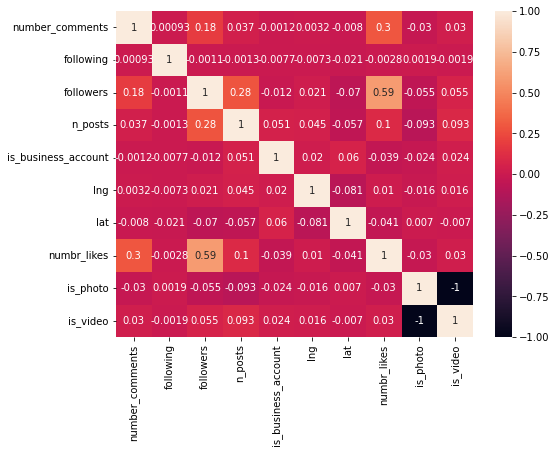

In [189]:
# visualise correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(df_train.corr(), annot=True)
plt.show()

The number of comments, number of follwoers, and number of posts have correlation >= 0.1 with the number of likes.

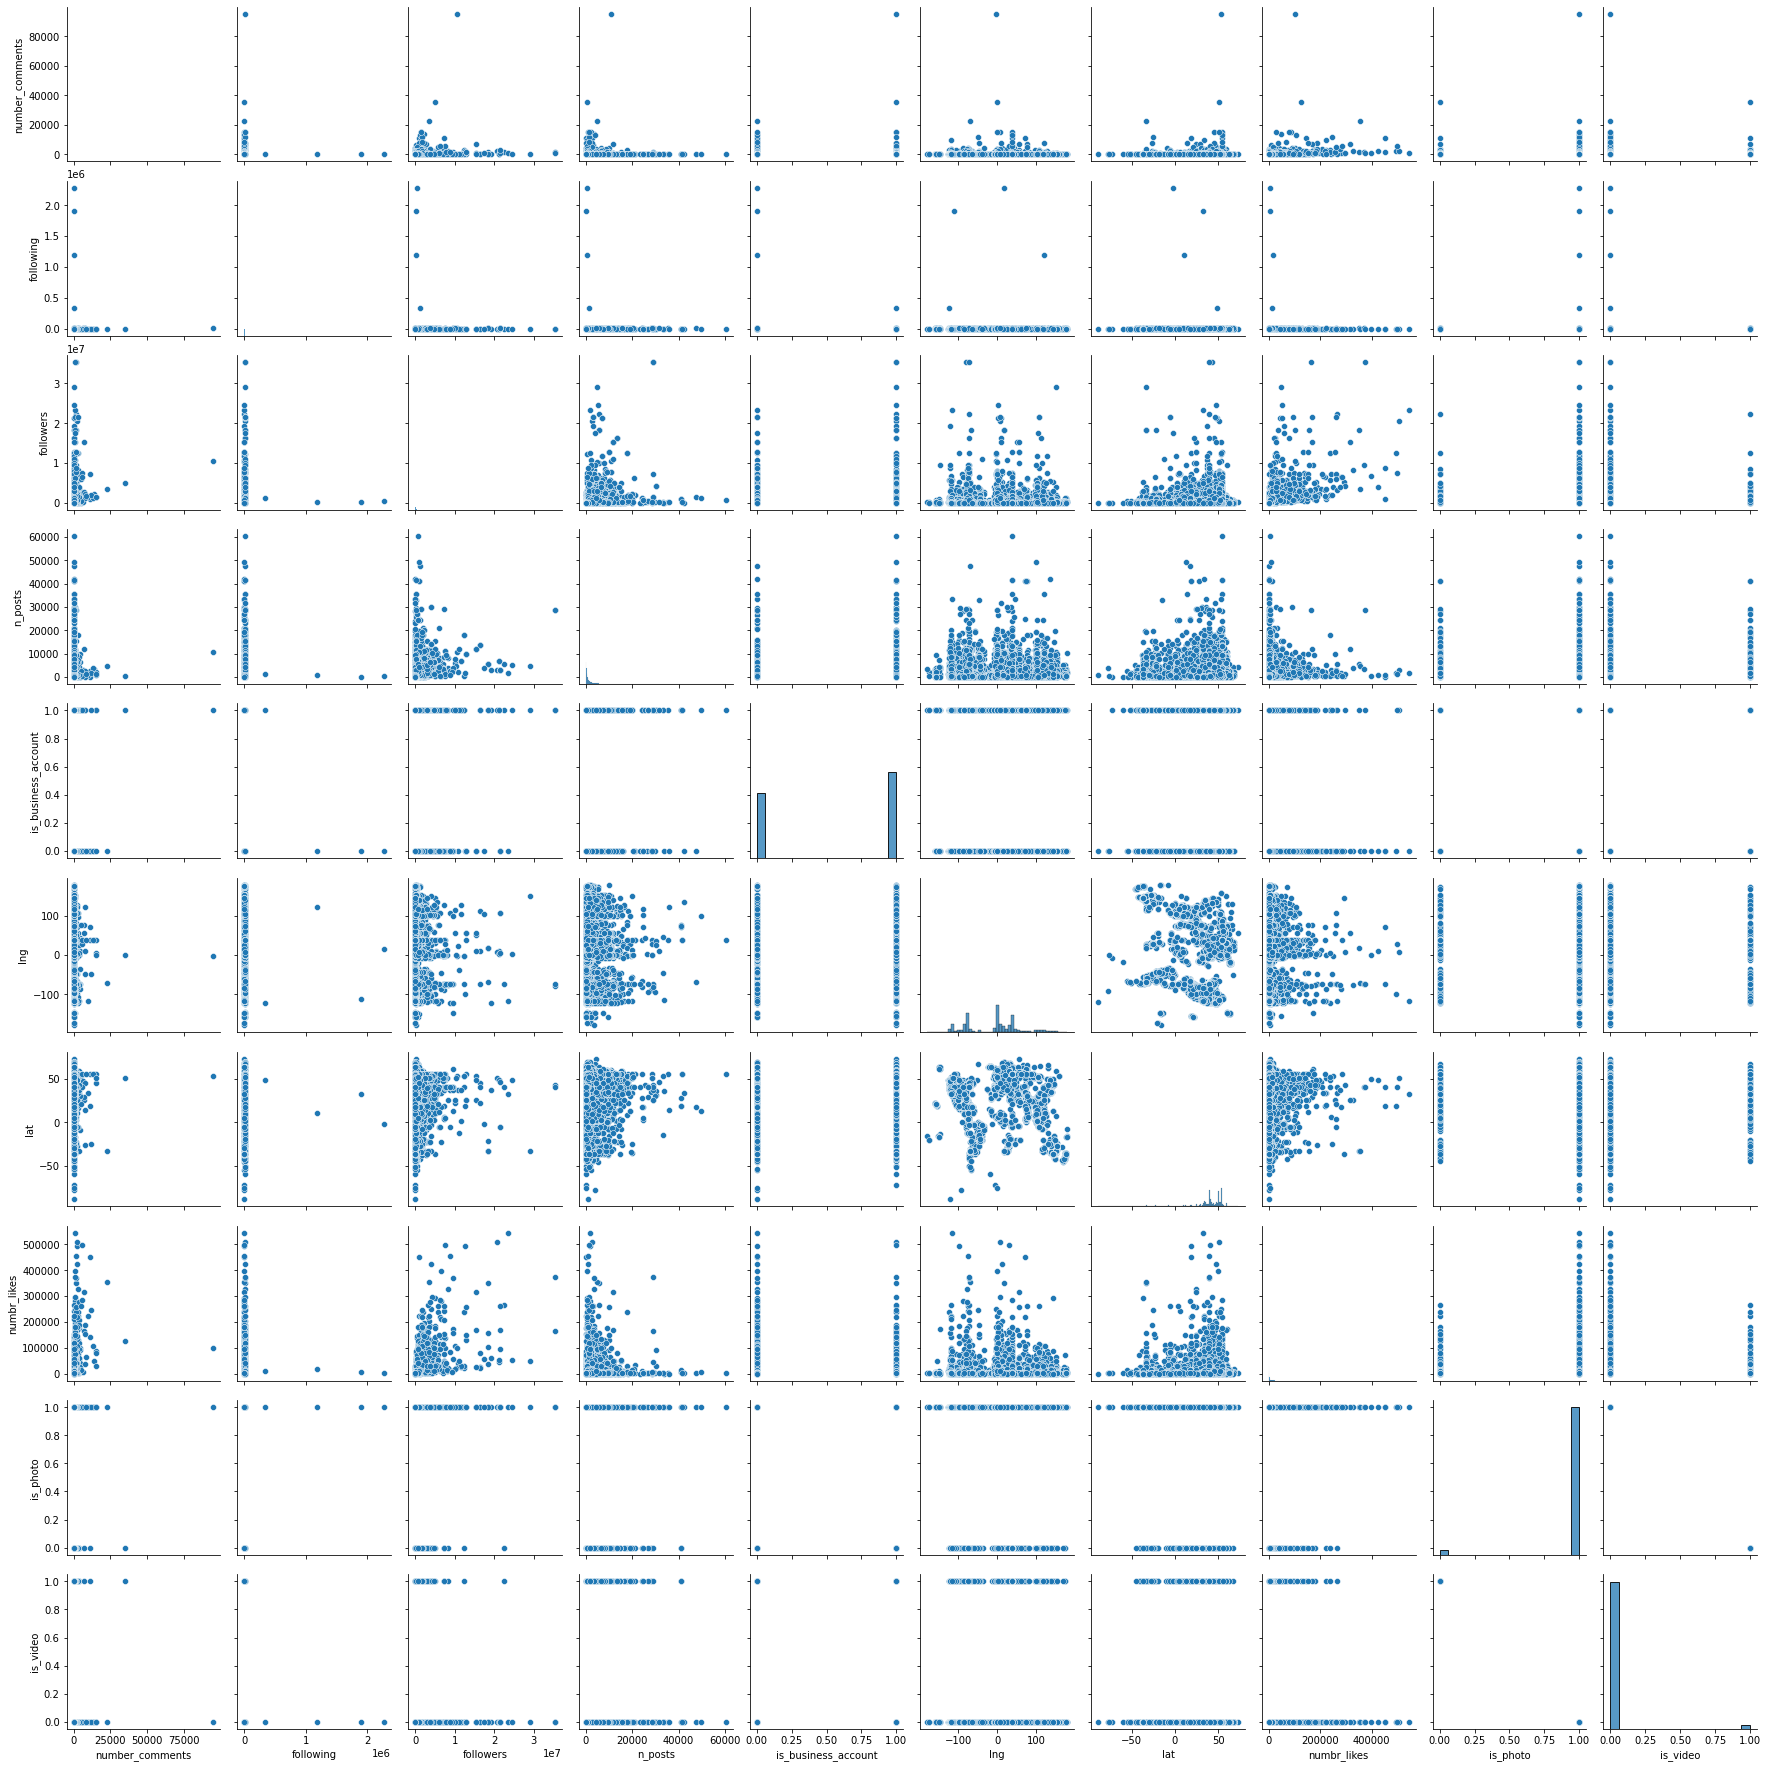

In [186]:
# visualise pairwise scatter plot
sns.pairplot(df_train)

The number of followers seems to have a power law relationship with the number of likes. Try visualising with log transformation on both variables.

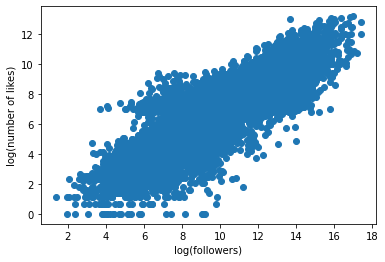

In [22]:
plt.figure()
plt.scatter(np.log(df_train['followers']), np.log(df_train['numbr_likes']))
plt.xlabel('log(followers)')
plt.ylabel('log(number of likes)')
plt.show()

The relationship here seems linear.

### Modelling

In [16]:
# get predictor and target variables
X = df_train[[i for i in df_train.columns if i != 'numbr_likes']]
y = df_train['numbr_likes']

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (22820, 9)
y shape:  (22820,)


In [17]:
# split predictors and target variables into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

#### Linear Regression

First, fit a linear regression model with all features.

In [151]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_val)
rmse_lr = mean_squared_error(y_val, pred_lr, squared=False)
rmse_lr

13205.256653628567

#### Linear regression with stepwise selection

Perform stepwise feature selection by removing features with the highest p-value, and verify that the AIC decreases after each step.

In [107]:
# full model
model1 = ols(
    formula='numbr_likes ~ number_comments + following + followers + n_posts + is_business_account + lng + lat + is_photo + is_video',
    data=df_train
).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            numbr_likes   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     1828.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:00:59   Log-Likelihood:            -2.5010e+05
No. Observations:               22820   AIC:                         5.002e+05
Df Residuals:                   22811   BIC:                         5.003e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2212.1067    

In [108]:
# longitude removed
model2 = ols(
    formula='numbr_likes ~ number_comments + following + followers + n_posts + is_business_account + lat + is_photo + is_video',
    data=df_train
).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            numbr_likes   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     2090.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:02:03   Log-Likelihood:            -2.5010e+05
No. Observations:               22820   AIC:                         5.002e+05
Df Residuals:                   22812   BIC:                         5.003e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2212.4156    

In [109]:
# latitude removed
model3 = ols(
    formula='numbr_likes ~ number_comments + following + followers + n_posts + is_business_account + is_photo + is_video',
    data=df_train
).fit()

print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:            numbr_likes   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     2438.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:03:11   Log-Likelihood:            -2.5010e+05
No. Observations:               22820   AIC:                         5.002e+05
Df Residuals:                   22813   BIC:                         5.003e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2175.9749    

In [110]:
# following column removed
model4 = ols(
    formula='numbr_likes ~ number_comments + followers + n_posts + is_business_account + is_photo + is_video',
    data=df_train
).fit()

print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:            numbr_likes   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     2926.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:04:32   Log-Likelihood:            -2.5010e+05
No. Observations:               22820   AIC:                         5.002e+05
Df Residuals:                   22814   BIC:                         5.003e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2173.5548    

In [111]:
# verify that AIC decreases after each step
print(model1.aic, model2.aic, model3.aic, model4.aic)

500222.50396426226 500220.546001416 500218.650894842 500216.90274529054


The features removed are `lng`, `lat`, and `following` respectively at each step. 

In [113]:
X_selected = X[['number_comments', 'followers', 'n_posts', 'is_business_account', 'is_photo', 'is_video']]

In [142]:
X_train_selected = X_train[['number_comments', 'followers', 'n_posts', 'is_business_account', 'is_photo', 'is_video']]
X_val_selected = X_val[['number_comments', 'followers', 'n_posts', 'is_business_account', 'is_photo', 'is_video']]

In [150]:
lr_selected = LinearRegression()
lr_selected.fit(X_train_selected, y_train)
pred_lr_selected = lr_selected.predict(X_val_selected)
rmse_lr_selected = mean_squared_error(y_val, pred_lr_selected, squared=False)
rmse_lr_selected

13205.434852801614

#### Linear regression with correlated features

The next model is fitted by selecting the three features that have a correlation coefficient >= 0.1 with the target variable.

In [190]:
X_train_selected2 = X_train[['number_comments', 'followers', 'n_posts']]
X_val_selected2 = X_val[['number_comments', 'followers', 'n_posts']]

In [191]:
lr_selected2 = LinearRegression()
lr_selected2.fit(X_train_selected2, y_train)
pred_lr_selected2 = lr_selected2.predict(X_val_selected2)
rmse_lr_selected2 = mean_squared_error(y_val, pred_lr_selected2, squared=False)
rmse_lr_selected2

13216.749584150262

#### Linear regression model with power law transformation

Based on the relationship between followers and number of likes, this model applies the power law between the two variables.

In [24]:
# create log variables
df_train['log_followers'] = np.log(df_train['followers'])
df_train['log_numbr_likes'] = np.log(df_train['numbr_likes'])
df_train.head()

,number_comments,following,followers,n_posts,is_business_account,lng,lat,numbr_likes,is_photo,is_video,log_followers,log_numbr_likes
0,78,420,594895,3612,1,2,41,4985,1.0,0.0,13.296140,8.514189
1,2,486,428,95,0,120,11,57,1.0,0.0,6.059123,4.043051
2,15,5378,36618,1259,1,11,51,1576,1.0,0.0,10.508295,7.362645
3,5,62,126,39,0,-118,52,29,1.0,0.0,4.836282,3.367296
4,11,544,45450,1251,1,30,59,1487,1.0,0.0,10.724368,7.304516


In [65]:
X_log = df_train['log_followers']
X_log.describe()

count    22820.000000
mean         9.936468
std          2.562858
min          1.386294
25%          7.787797
50%         10.257344
75%         11.829468
max         17.380518
Name: log_followers, dtype: float64

In [66]:
y_log = df_train['log_numbr_likes']

In [42]:
y_log.describe()

count    2.282000e+04
mean             -inf
std               NaN
min              -inf
25%      5.345914e+00
50%      7.211557e+00
75%      8.051022e+00
max      1.320694e+01
Name: log_numbr_likes, dtype: float64

In [38]:
# examine target variables which are -inf
y_log.loc[y_log == float("-inf")]

1334    -inf
1391    -inf
2332    -inf
2583    -inf
3483    -inf
3734    -inf
3968    -inf
3988    -inf
4010    -inf
6715    -inf
6778    -inf
7641    -inf
9139    -inf
10305   -inf
11827   -inf
12330   -inf
13763   -inf
16875   -inf
18086   -inf
18271   -inf
21690   -inf
Name: log_numbr_likes, dtype: float64

In [67]:
# obtain indices of rows which contain -inf
inf_index = y_log.loc[y_log == float("-inf")].index
inf_index

Int64Index([ 1334,  1391,  2332,  2583,  3483,  3734,  3968,  3988,  4010,
             6715,  6778,  7641,  9139, 10305, 11827, 12330, 13763, 16875,
            18086, 18271, 21690],
           dtype='int64')

In [68]:
# drop rows which contain -inf in the target variable
y_log.drop([i for i in inf_index], inplace=True)

In [69]:
# check that the rows with -inf have been dropped
y_log.loc[y_log == float("-inf")]

Series([], Name: log_numbr_likes, dtype: float64)

In [70]:
len(y_log)

22799

In [71]:
# drop those rows in predictor variables 
X_log.drop([i for i in inf_index], inplace=True)

In [72]:
# check that the rows have been dropped
len(X_log)

22799

In [73]:
# perform train-test split
X_log = np.array(X_log).reshape((-1, 1))

X_log_train, X_log_val, y_log_train, y_log_val = train_test_split(X_log, y_log, train_size=0.8, random_state=42)

In [102]:
lr_log = LinearRegression()
lr_log.fit(X_log_train, y_log_train)
pred_log = lr_log.predict(X_log_val)
rmse_log = mean_squared_error(np.exp(y_log_val), np.exp(pred_log), squared=False)
rmse_log

12107.128584114911

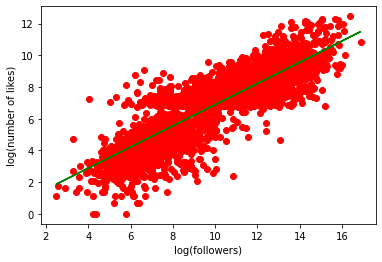

In [99]:
plt.figure()
plt.scatter(X_log_val, y_log_val, color='red')
plt.plot(X_log_val, pred_log, color='green')
plt.xlabel('log(followers)')
plt.ylabel('log(number of likes)')
plt.show()

#### Elastic Net

This model searches for the best l1_ratio and alpha values, and implement Elastic Net.

In [95]:
# scale predictors to have mean of 0 and standard deviation of 1
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X))

pd.options.display.float_format = '{:,.4f}'.format
X_std.describe().loc[['mean', 'std']]

,0,1,2,3,4,5,6,7,8
mean,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [144]:
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train))
X_val_std = pd.DataFrame(scaler.fit_transform(X_val))

In [98]:
# define range of alphas (l1_ratio) and lambdas (alpha) to be passed to the model
l1_ratio = [.1, .3, .5, .7, .9, .95, .99, 1]
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

In [146]:
elastic_net_model = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, max_iter=2000)
elastic_net_model.fit(X_train_std, y_train)
pred_en = elastic_net_model.predict(X_val_std)
rmse_en = mean_squared_error(y_val, pred_en, squared=False)
rmse_en

13906.180527457604

#### Principal Component Regression & Elastic Net

This model implements Principal Component Regression and Elastic Net.

In [198]:
scaler = StandardScaler()
pca = PCA()
elasticnet = ElasticNet()

pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('elasticnet', elasticnet)])

In [205]:
n_components = list(range(1,X.shape[1]+1,1))
l1_ratio = [.1, .3, .5, .7, .8, .9, .95, .99, 1]
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

parameters = dict(pca__n_components=n_components, elasticnet__l1_ratio=l1_ratio, elasticnet__alpha=alphas)

In [206]:
elasticnet_cv = GridSearchCV(pipeline, parameters)
elasticnet_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1,
                                               0.0, 1.0, 10.0, 100.0],
                         'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.8, 0.9,
                                                  0.95, 0.99, 1],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9]})

In [207]:
print('Best Number Of Components:', elasticnet_cv.best_estimator_.get_params()['pca__n_components'])
print(elasticnet_cv.best_estimator_.get_params()['elasticnet'])

Best Number Of Components: 8
ElasticNet(alpha=10.0, l1_ratio=0.95)


In [208]:
pred_en2 = elasticnet_cv.predict(X_val)
rmse_en2 = mean_squared_error(y_val, pred_en2, squared=False)
rmse_en2

14382.032633872703

## Test dataset

Now apply the same data cleaning and feature engineering steps to the test set.

### Data cleaning

In [115]:
df_test.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,location_id,profile_id,sid,sid_profile,post_id,post_type,description,...,region,cd,phone,aj_exact_city_match,aj_exact_country_match,blurb,dir_city_name,dir_country_name,lat,lng
0,0,6905,7115,16628794,433011845,37849814,3681636,BzGxKpjJR7O,1,When you pree her insta and she‚Äôs deleted th...,...,NaN,GB,01234 351115,False,False,Bedford International Athletic Stadium has acq...,Bedford,United Kingdom,0,52
1,1,22270,22924,13404453,28319341,38354690,3750553,By4UVohp7K3,1,Favourite yoga/ pilates/ fitness studios in Ba...,...,NaN,TH,NaN,True,False,NaN,Bangkok,Thailand,100,13
2,2,8449,8708,238342740,2280748136,14982216,3441757,BxFgEf7n7QB,1,Will never get over how beautiful this place i...,...,NaN,FO,NaN,False,False,NaN,NaN,NaN,-6,61
3,3,25778,26526,221023562,23814473,26521031,3803545,BmDEGOMAfZZ,1,Jag hann. Men det hade inte g√•tt utan min v√§...,...,NaN,SE,0647-353 00,False,False,V√•l√•dalen ligger d√§r √§ventyret b√∂rjar. H√...,NaN,NaN,12,63
4,4,26248,27010,710819371,303411945,36798813,3765067,ByUwqJMIJIv,1,–ö–æ–≥–¥–∞ —É —Ç–µ–±—è –æ–¥–Ω–∏ –ø–ª–∞–Ω—ã –Ω–...,...,NaN,RU,+7 495 937 90 40,False,False,NaN,NaN,NaN,37,55


In [116]:
df_test.shape

(5731, 32)

In [117]:
df_test.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'location_id',
       'profile_id', 'sid', 'sid_profile', 'post_id', 'post_type',
       'description', 'numbr_likes', 'number_comments', 'profile_name',
       'firstname_lastname', 'following', 'followers', 'n_posts', 'url',
       'is_business_account', 'name', 'zip', 'city', 'region', 'cd', 'phone',
       'aj_exact_city_match', 'aj_exact_country_match', 'blurb',
       'dir_city_name', 'dir_country_name', 'lat', 'lng'],
      dtype='object')

In [75]:
# remove first three unnamed columns
df_test = df_test[[col for col in df_test.columns[3:]]]
df_test.head()

,location_id,profile_id,sid,sid_profile,post_id,post_type,description,numbr_likes,number_comments,profile_name,...,region,cd,phone,aj_exact_city_match,aj_exact_country_match,blurb,dir_city_name,dir_country_name,lat,lng
0,16628794,433011845,37849814,3681636,BzGxKpjJR7O,1,When you pree her insta and she‚Äôs deleted th...,NaN,111,tj_athlete,...,NaN,GB,01234 351115,False,False,Bedford International Athletic Stadium has acq...,Bedford,United Kingdom,0,52
1,13404453,28319341,38354690,3750553,By4UVohp7K3,1,Favourite yoga/ pilates/ fitness studios in Ba...,NaN,29,madiross,...,NaN,TH,NaN,True,False,NaN,Bangkok,Thailand,100,13
2,238342740,2280748136,14982216,3441757,BxFgEf7n7QB,1,Will never get over how beautiful this place i...,NaN,67,droneofficial,...,NaN,FO,NaN,False,False,NaN,NaN,NaN,-6,61
3,221023562,23814473,26521031,3803545,BmDEGOMAfZZ,1,Jag hann. Men det hade inte g√•tt utan min v√§...,NaN,46,bingorimer,...,NaN,SE,0647-353 00,False,False,V√•l√•dalen ligger d√§r √§ventyret b√∂rjar. H√...,NaN,NaN,12,63
4,710819371,303411945,36798813,3765067,ByUwqJMIJIv,1,–ö–æ–≥–¥–∞ —É —Ç–µ–±—è –æ–¥–Ω–∏ –ø–ª–∞–Ω—ã –Ω–...,NaN,6,juliabodyul,...,NaN,RU,+7 495 937 90 40,False,False,NaN,NaN,NaN,37,55


In [124]:
df_test.sid.nunique()

5720

In [76]:
df_test.rename(columns = {'lat':'lng', 'lng':'lat'}, inplace = True)

In [77]:
# keep relevant variables and use sid as the index column
predictors = ['post_type', 'number_comments', 'following', 'followers', 'n_posts', 'is_business_account', 'lng', 'lat', 'numbr_likes']
df_test = df_test[[col for col in predictors]]
df_test.head()

,post_type,number_comments,following,followers,n_posts,is_business_account,lng,lat,numbr_likes
0,1,111,805,17491,257.0,False,0,52,NaN
1,1,29,583,357246,1339.0,True,100,13,NaN
2,1,67,1258,128176,1913.0,True,-6,61,NaN
3,1,46,2329,172429,8090.0,True,12,63,NaN
4,1,6,244,10253,511.0,False,37,55,NaN


In [78]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5731 entries, 0 to 5730
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_type            5731 non-null   int64  
 1   number_comments      5731 non-null   int64  
 2   following            5731 non-null   int64  
 3   followers            5731 non-null   int64  
 4   n_posts              5731 non-null   float64
 5   is_business_account  5731 non-null   bool   
 6   lng                  5731 non-null   int64  
 7   lat                  5731 non-null   int64  
 8   numbr_likes          0 non-null      float64
dtypes: bool(1), float64(2), int64(6)
memory usage: 363.9 KB


In [103]:
# convert is_business_account column to integers
df_test['is_business_account'] = df_test['is_business_account'].replace({True: 1, False: 0})

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5731 entries, 0 to 5730
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   number_comments      5731 non-null   int64  
 1   following            5731 non-null   int64  
 2   followers            5731 non-null   int64  
 3   n_posts              5731 non-null   float64
 4   is_business_account  5731 non-null   int64  
 5   lng                  5731 non-null   int64  
 6   lat                  5731 non-null   int64  
 7   numbr_likes          0 non-null      float64
 8   is_photo             5731 non-null   float64
 9   is_video             5731 non-null   float64
 10  log_followers        5731 non-null   float64
 11  log_numbr_likes      0 non-null      float64
dtypes: float64(6), int64(6)
memory usage: 537.4 KB


### Feature engineering

In [79]:
# one-hot encode post type column
ohe = OneHotEncoder()
df_test[['is_photo', 'is_video']] = ohe.fit_transform(df_test[['post_type']]).toarray()

In [80]:
# drop post type column
df_test = df_test[[i for i in df_test.columns if i != 'post_type']]
df_test.head()

,number_comments,following,followers,n_posts,is_business_account,lng,lat,numbr_likes,is_photo,is_video
0,111,805,17491,257.0,False,0,52,NaN,1.0,0.0
1,29,583,357246,1339.0,True,100,13,NaN,1.0,0.0
2,67,1258,128176,1913.0,True,-6,61,NaN,1.0,0.0
3,46,2329,172429,8090.0,True,12,63,NaN,1.0,0.0
4,6,244,10253,511.0,False,37,55,NaN,1.0,0.0


In [81]:
# get predictors
X_test = df_test[[i for i in df_test.columns if i != 'numbr_likes']]

print('X test shape: ', X_test.shape)

X test shape:  (5731, 9)


In [82]:
# add log of followers column
df_test['log_followers'] = np.log(df_test['followers'])

### Prediction

In [183]:
# scale predictors
scaler = StandardScaler()
X_test_std = pd.DataFrame(scaler.fit_transform(X_test))

pd.options.display.float_format = '{:,.4f}'.format
X_test_std.describe().loc[['mean', 'std']]

,0,1,2,3,4,5,6,7,8
mean,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000
std,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001


Model 1: Elastic Net model

In [184]:
# predictions from Elastic Net model
y_pred_en = elastic_net_model.predict(X_test_std)
y_pred_en

array([ 3997.68571922,  5060.110554  ,  3489.90363714, ...,
        2371.0158804 ,  2402.64467697, 26500.89550695])

In [177]:
submission = pd.DataFrame({'id': range(df_test.shape[0]),'numbr_likes': y_pred_en})
submission.to_csv('prediction_en_1.csv', index=False)

Model 2: model with full features

In [185]:
# prediction from linear regression model with full features
y_pred_lr = lr.predict(X_test)
y_pred_lr

array([ 3749.81763733,  5544.56883314,  2998.1898795 , ...,
        2029.47792354,  2077.18508919, 39668.83000963])

In [179]:
submission = pd.DataFrame({'id': range(df_test.shape[0]),'numbr_likes': y_pred_lr})
submission.to_csv('prediction_lr_1.csv', index=False)

Model 3: model with stepwise selection

In [154]:
X_test_selected = X_test[['number_comments', 'followers', 'n_posts', 'is_business_account', 'is_photo', 'is_video']]

In [155]:
# predictions from linear regression model with stepwise selection
y_pred_lr_selected = lr_selected.predict(X_test_selected)
y_pred_lr_selected

array([ 3758.35593243,  5477.46681705,  3019.47558347, ...,
        2026.3055432 ,  2072.36179582, 39686.48761341])

In [180]:
submission = pd.DataFrame({'id': range(df_test.shape[0]),'numbr_likes': y_pred_lr_selected})
submission.to_csv('prediction_lr_2.csv', index=False)

Model 4: model with predictors most correlated with target variable 

In [192]:
X_test_selected2 = X_test[['number_comments', 'followers', 'n_posts']]

In [193]:
# predictions from linear regression model with predictors most correlated with target variable 
y_pred_lr_selected2 = lr_selected2.predict(X_test_selected2)
y_pred_lr_selected2

array([ 3194.91956009,  5921.97596583,  3454.31305529, ...,
        2472.58453406,  2520.49302154, 40142.14428562])

In [194]:
submission = pd.DataFrame({'id': range(df_test.shape[0]),'numbr_likes': y_pred_lr_selected2})
submission.to_csv('prediction_lr_3.csv', index=False)

Model 5: model with PCR-Elastic Net pipeline

In [209]:
# predictions from PCR-Elastic Net pipeline model
y_pred_en2 = elasticnet_cv.predict(X_test)
y_pred_en2

array([ 3698.63077197,  5279.17355607,  3434.93022925, ...,
        2516.8104719 ,  2570.61504382, 28184.68114292])

In [210]:
submission = pd.DataFrame({'id': range(df_test.shape[0]),'numbr_likes': y_pred_en2})
submission.to_csv('prediction_en_2.csv', index=False)

Model 6: model with power law transformation

In [85]:
X_test_log = np.array(df_test['log_followers']).reshape((-1,1))

In [89]:
# predictions from model with power law
y_pred_log = lr_log.predict(X_test_log)
y_pred_log

array([ 6.74364926,  8.76099294,  8.07554458, ...,  5.55409233,
        5.19884452, 10.34749462])

In [91]:
# transform log of predictions back to actual values
y_pred_log = np.exp(y_pred_log)

In [92]:
submission = pd.DataFrame({'id': range(df_test.shape[0]),'numbr_likes': y_pred_log})
submission.to_csv('prediction_log.csv', index=False)